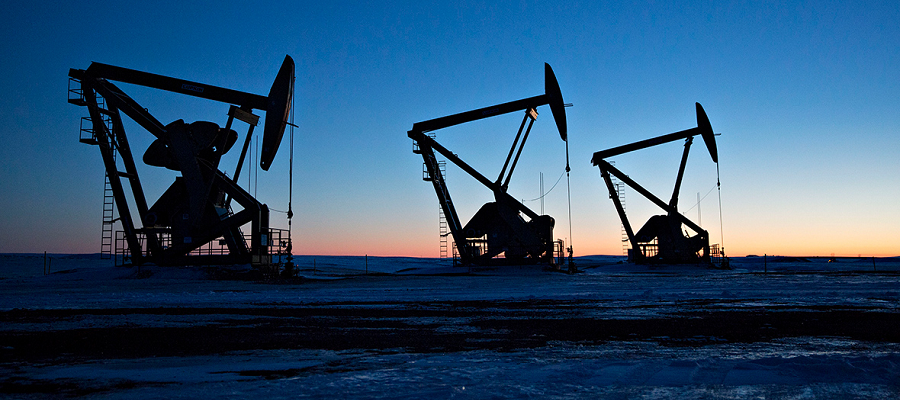

# <center> Прогнозирование выработки газа на скважинах

## Легенда

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять специалиста в области Data Science.

Василий представляет нам набор данных о добыче газа на своих скважинах.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Наша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты нашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
from sklearn import metrics # метрики
import optuna # для подбора гиперпараметров
from sklearn.preprocessing import PolynomialFeatures # для создания полиномиальных признаков
from sklearn.preprocessing import StandardScaler # для стандартизации данных
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet # линейный модели
from sklearn.model_selection import GridSearchCV # также для подбора гиперпараметров
from sklearn.model_selection import cross_validate, cross_val_score # кросс-валидация
# Для удобочитаемости пожертвуем отчетностью варнов
import warnings 
warnings.filterwarnings('ignore')
# Для рендеринга фигур непосредственно в ноутбуке
%matplotlib inline

Прочитаем исходные данные:

In [2]:
data = pd.read_csv('data/_unconv.zip')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Небольшой разведывательный анализ

Проведем анализ, чтобы поближе познакомиться с исходными данными. Построим несколько визуализаций, которые помогут понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов.

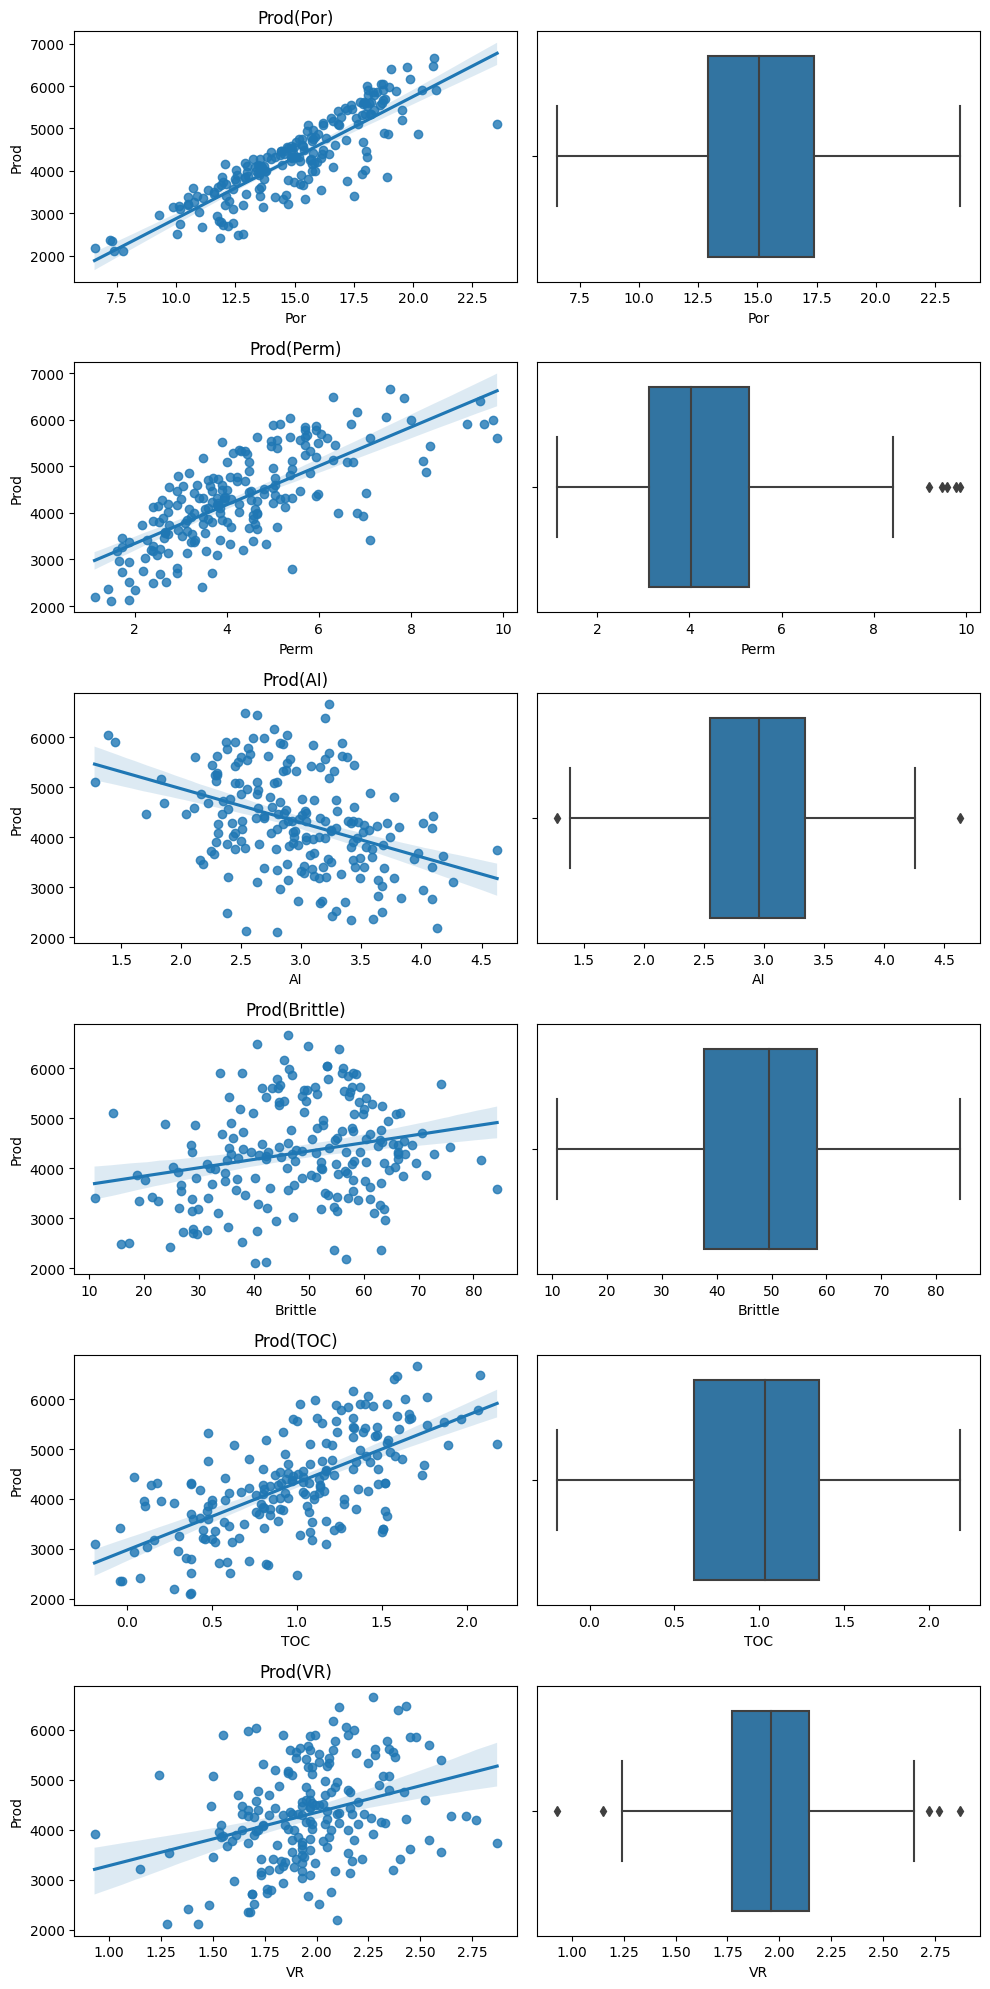

In [3]:
# Визуализируем распределения признаков
fig, axes = plt.subplots(6, 2, figsize=(10, 20))
# Обходим через цикл наши фичи
for i, col in enumerate(data.columns[1:-1]):
    # Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data, x=col, y='Prod', ax=axes[i][0])
    # Добавляем подпись к графику
    regplot.set_title('Prod({})'.format(col))
    # Строим коробчатую диаграмму для признака
    sns.boxplot(x=data[col], ax=axes[i][1])

plt.tight_layout() # Выравнивание графиков

**Выводы:**
* Мы можем наблюдать хорошую взаимосвязь между целевым признаком Prod (добыча газа в сутки) и пористостью скважины (Por).
* Prod также неплохо свзяан с проницаемостью скважины (Perm).
* Наблюдается слабая обратная связь Prod с акустическим импедансом (AI).
* Также слабая положительная связь Prod с коэффициентом хрупкости скважины (Brittle).
* Есть неплохая положительная связь Prod с процентным содержанием общего органического углерода (TOC).
* Имеется слабовыраженная положительная связь Prod с коэффициентом отражения витринита (VR).

## Часть 1. Линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

Построим корреляционную матрицу факторов, включив в неё целевой признак. Для наглядности визуализируем полученную матрицу с помощью тепловой карты. 

Ранг матрицы: 8
Определитель: 0.00073


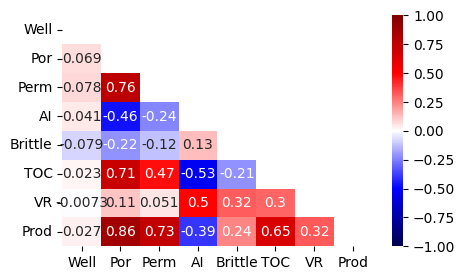

In [4]:
# Матрица корреляций
data_corr = data.corr()
# Выведем тепловую карту на основе матрицы корреляций
matrix = np.triu(data_corr) # Треугольная маска
fig, axes = plt.subplots(figsize=(5, 3))
# Тепловая карта
sns.heatmap(
    data_corr, vmin=-1, vmax=1, cmap='seismic',
    annot=True, mask=matrix, ax=axes
);
# Параметры матрицы
print('Ранг матрицы:', np.linalg.matrix_rank(data_corr))
print('Определитель:', np.round(np.linalg.det(data_corr), 6))

>**Выводы.**<br> Как это видно было уже на стадии визуализации распределений признаков, сильнее всего с целевой переменной коррелируют пористость (Por) и проницаемость (Perm) скважины, а также процентное содержание общего органического углерода (TOC).<br>По значению определителя можно утверждать, что наша матрица относится к плохо обусловленным.<br>
Чистой коллинеарности в нашей матрице нет: ранг матрицы равен числу векторов-признаков. Однако имеется сильная корреляция в парах Por-Perm и Por-TOC.<br>В данном случае модель классической линейной регрессии всё же применима, т.к. матрица корреляций не является вовсе вырожденной. Поправить значение определителя матрицы можно убрав один-два сильно скореллированных признака (например, те же Por и Perm) и лишний вектор индексов Well.

Разделим датасет на матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмем все имеющиеся в данных признаки. 

Построим модель линейной регрессии по методу наименьших квадратов. Для этого воспользуемся матричной формулой МНК и инструментарием библиотеки numpy.

In [5]:
# Задаем матрицу наблюдений и вектор правильных ответов
X = np.column_stack((np.ones(200), data[data.columns[:-1]]))
y = data.Prod
# Строим модель линейной регрессии по методу наименьших квадратов
OLS_models_ws = np.linalg.inv(X.T @ X) @ X.T @ y
print(f'Коэффициенты модели:')
print(*np.round(OLS_models_ws), sep=' | ')

Коэффициенты модели:
-1232.0 | 0.0 | 230.0 | 116.0 | -365.0 | 25.0 | -78.0 | 785.0


>**Выводы.**<br>Как нам снова напоминают результаты расчета коэффициентов чистой OLS-модели, у нас есть неинформативный вектор-столбец индексов скважин Well.<br>
Судя по получившимся коэффициентам, модель стремится обьяснить данные следующим образом: при росте показателя пористости скважины на один процент - добыча газа в сутки возрастет на дополнительные 230 млн. кубических футов; лидирующим фактором среди обеспечивающих прирост добычи является коэффциент отражения витринита: при росте на процент - добыча возрастет на 785 млн. куб. фут. в сутки; однако при росте, например, акустического импеданса на одну условную единицу производительность скважины снизится на 365 млн. куб. фут. в сутки.

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Построим прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитаем абсолютную ошибку построенного нами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Построим прогноз выработки газа для всех скважин из обучающего набора данных. Выберем метрику, по которой будем оценивать качество регрессионных моделей и сравнивать их между собой.

Рассчитаем значение выбранной метрики для нашей модели и проведем интерпретацию полученного результата. 

In [6]:
# Параметры скважины
well_params = {
    'intrcpt': 1, 'Well': 106.0, 'Por': 15.32, 'Perm': 3.71,
    'AI': 3.29,'Brittle': 55.99,'TOC': 1.35,'VR': 2.42
}
# Предсказание объема добычи
predict_Prod_106 = sum(
    OLS_models_ws[i] * list(well_params.values())[i] for i in range(8)
)
print('Предсказанный объем добычи:', round(predict_Prod_106, 6))
print('Absolute prediction error:', round(
    float(data[data['Well'] == 106]['Prod'] - predict_Prod_106), 2)
)
# Предсказание объема добычи для всех скважин
predict_Prod = X @ OLS_models_ws
# Выводим значения метрик
print('MAE:', round(metrics.mean_absolute_error(y, predict_Prod), 3))
print('MAPE:', round(metrics.mean_absolute_percentage_error(y, predict_Prod) *100, 1), '%')

Предсказанный объем добычи: 4723.064054
Absolute prediction error: 25.25
MAE: 153.623
MAPE: 3.6 %


>**Выводы**.<br>У нас получилась довольно качественная модель, описывающая взаимосвязь целевого признака посуточного объема добычи газа и характеристик скважин: ошибка модели варьирует в пределах 3,6 % (или максимум 154 млн. куб. фут.).

Настало время анализа построенной модели. Посмотрим на коэффициенты и сравним их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые мы нашли ранее.

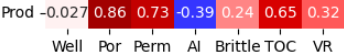

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);

In [7]:
# Составим таблицу коэффициентов модели
df_coefs = pd.DataFrame(
    data=[list(np.round(OLS_models_ws))],
    columns=['Intercept'] + list(data.columns)[:-1]
)
# Выведем таблицу
df_coefs

,Intercept,Well,Por,Perm,AI,Brittle,TOC,VR
0,-1232.0,0.0,230.0,116.0,-365.0,25.0,-78.0,785.0


>**Выводы.**<br>В нашей модели действительно есть фактор, коэффициент при котором имеет иной знак, нежели тот, что мы наблюдали при значении корреляции этого фактора с целевым признаком в ранее расчитанной матрице корреляций. И этот фактор — общий органический углерод (TOC).<br>
Видимо, так получилось потому, что наши данные, как мы это установили ранее, загрязнены мултиколлинеарными связями.

План дальнейших действий:

1. Исключим из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`. Выбирая, какой из коррелированных факторов оставить, будем руководствоваться коэффициентом корреляции с целевой переменной: оставим тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).
2. Также исключим из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.
3. Построим модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуемся матричной формулой и библиотекой numpy.
4. Сделаем прогноз для всего обучающего набора данных и рассчитаем метрики.

In [8]:
# Задаем матрицу наблюдений и вектор правильных ответов
data_mod = data.drop(['Well', 'Perm', 'TOC'], axis=1)
X_mod = np.column_stack((np.ones(200), data_mod[data_mod.columns[:-1]]))
# Строим модель линейной регрессии по методу наименьших квадратов
OLS_models_ws_for_mod = np.linalg.inv(X_mod.T @ X_mod) @ X_mod.T @ y
# Составим таблицу коэффициентов модели
df_mod_coefs = pd.DataFrame(
    data=[list(np.round(OLS_models_ws_for_mod))],
    columns=['Intercept'] + list(data_mod.columns)[:-1]
)
print('Было:')
display(df_coefs)
print('Стало:')
display(df_mod_coefs)
# Предсказание объема добычи для всех скважин
predict_Prod_mod = X_mod @ OLS_models_ws_for_mod
# Выводим значения метрик
print('MAE:', round(metrics.mean_absolute_error(y, predict_Prod_mod), 3))
print('MAPE:', round(metrics.mean_absolute_percentage_error(y, predict_Prod_mod) *100, 2), '%')

Было:


,Intercept,Well,Por,Perm,AI,Brittle,TOC,VR
0,-1232.0,0.0,230.0,116.0,-365.0,25.0,-78.0,785.0


Стало:


,Intercept,Por,AI,Brittle,VR
0,-1835.0,293.0,-200.0,28.0,517.0


MAE: 171.431
MAPE: 4.04 %


> **Выводы.**<br>На этот раз модель описывает данные следующим образом: производительность скважины возрастет на 293 млн. куб. фут. в сутки при увеличении пористости на один процент; ранее прогнозировалось увеличение на 230. Т.о. мы можем отметить, что влияние этого фактора в модели возросло, иной же случай с акустическим импедансом и коэффициентом отражения витринита - тут влиние факторов на модель снизилось: теперь изменению AI на единицу вменяется соответствующее изменение производительности лишь на 200 млн. куб. фут (ранее - на 365).<br>
Значения метрик стали немного хуже, чем в предыдущей модели: ошибка модели теперь варьирует в пределах 4 % (или максимум 171 млн. куб. фут.); ранее мы имели 3,6 % (или 154 млн. куб. фут.).<br>
Однако, увы, мы не можем утверждать, что нам удалось побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции, т.к. новая модель вовсе не учитывает фактор ТОС, который и вел себя в рамках прежней модели противоречивым образом.

Наконец, построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную.

Построим модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов.

Сделаем прогноз для всего обучающего набора данных и рассчитаем значения метрик.

Сравним результаты библиотечной реализации с тем, что мы получили ранее.

In [9]:
# Инициализируем объект класса линейная регрессия
lr = LinearRegression()
# Обучаем модель - ищем параметры
lr.fit(X_mod, y)
#Делаем предсказание
y_pred_lr = lr.predict(X_mod)
# Выведем значение свободного члена модели
print(f'Величина свободного члена модели: {round(lr.intercept_)}')
# Выведем коэффициенты модели
print(f'Коэффициенты модели: {np.round(lr.coef_)}')
# Рассчитаем метрики
lr_mae = round(metrics.mean_absolute_error(y, y_pred_lr), 2)
lr_mape = str(round(metrics.mean_absolute_percentage_error(y, y_pred_lr)*100, 2)) + ' %'
# Выводим значения метрик
print('MAE:', lr_mae)
print('MAPE:', lr_mape)

Величина свободного члена модели: -1835
Коэффициенты модели: [   0.  293. -200.   28.  517.]
MAE: 171.43
MAPE: 4.04 %


> **Выводы.**<br>Библиотечная реализация линейной регрессии дала нам те же результаты, что и реализация посредством матричных расчетов: коэффициенты и метрики получились одинаковыми.

## Часть 2. Полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. Далее мы также будем использовать именно их.

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию.

Для начала стандаризируем признаки с помощью `StandartScaler` из библиотеки `sklearn`. Затем сгенерируем полиномиальные признаки третьего порядка на факторах, которые мы выбрали для обучения моделей. Для этого воспользуемся генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установим в значение `False`, т.к. столбец единиц уже присутствует.

Далее Обучим модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах. Используя кросс-валидацию оценим среднее значения метрик на тренировочных и валидационных фолдах. И проинтерпретируем полученные результаты.

In [10]:
# Инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# Стандартизируем признаки
X_mod_skaled = scaler.fit_transform(X_mod)
# Добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X_mod_poly = poly.fit_transform(X_mod_skaled)
# Выведем количество факторов
print('Итоговое количество факторов:', X_mod_poly.shape[1])
# Инициализируем объект класса линейная регрессия
lr_poly = LinearRegression()
# Оцениваем качество модели на кросс-валидации
cv_res_lr_poly = cross_validate(
    lr_poly, X_mod_poly, y,
    scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'],
    cv=5, return_train_score=True)
# Вычисляем и выводим метрики
lr_poly_MAE_train = round(
    -cv_res_lr_poly['train_neg_mean_absolute_error'].mean(),2)
lr_poly_MAE_valid = round(
    -cv_res_lr_poly['test_neg_mean_absolute_error'].mean(), 2)
lr_poly_MAPE_train = str(
    round(-cv_res_lr_poly['train_neg_mean_absolute_percentage_error'].mean() * 100, 2)) + ' %'
lr_poly_MAPE_valid = str(
    round(-cv_res_lr_poly['test_neg_mean_absolute_percentage_error'].mean() * 100, 2)) + ' %'
print('MAE на тренировочных фолдах:', lr_poly_MAE_train)
print('MAE на валидационных фолдах:', lr_poly_MAE_valid)
print('MAPE на тренировочных фолдах:', lr_poly_MAPE_train)
print('MAPE на валидационных фолдах:', lr_poly_MAPE_valid)

Итоговое количество факторов: 55
MAE на тренировочных фолдах: 246.16
MAE на валидационных фолдах: 303.47
MAPE на тренировочных фолдах: 6.29 %
MAPE на валидационных фолдах: 7.39 %


> **Выводы.**<br>Результат пока что, увы, хуже, чем у полиномиальной регрессии первой степени (По крайней мере, если мы говорим о метриках модели на тренировочной выборке: ранее мы получили 171.4 (MAE) и 4.0 % (MAPE). Приблизительно такие же результаты мы получим здесь, если выставим параметр poly - degree=1).

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучим модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберем с помощью метода подбора гиперпаметров.

Используя кросс-валидацию, оценим среднее значения метрик на тренировочных и валидационных фолдах. Проинтерпретируем полученные результаты.

In [11]:
# Напишем функцию для оптимизации
def optuna_lasso(trial):
    """Функция, обучающая модель Lasso по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика MAPE
    """
    # Задаем пространство поиска гиперпараметров
    alpha = trial.suggest_float('alpha', 0.1, 1)
    # Создаем модель
    model = Lasso(alpha=alpha, max_iter=10000, fit_intercept=False)
    # Рассчитываем метрику на кросс-валидации
    score = cross_val_score(
        model, X_mod_poly, y, cv=5,
        scoring='neg_mean_absolute_percentage_error',
        n_jobs=-1).mean()
    return score

# Создаем объект исследования для гиперпараметров
study_lasso = optuna.create_study(study_name="lasso_opt", direction="minimize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_lasso.optimize(optuna_lasso, n_trials=20)
lasso_alfa = round(study_lasso.best_params['alpha'], 4)
print('Лучшая альфа:', lasso_alfa)
print('MAPE на обучающем наборе: {:.2f} %\n'.format(-study_lasso.best_value))

# Передаем модели коллекцию оптимальных гиперпараметров
lasso_opt = Lasso(**study_lasso.best_params)
# Оцениваем качество модели на кросс-валидации
cv_res_lasso = cross_validate(
    lasso_opt, X_mod_poly, y,
    scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'],
    cv=5, return_train_score=True)
# Вычисляем и выводим метрики
lasso_opt_MAE_train = round(
    -cv_res_lasso['train_neg_mean_absolute_error'].mean(),2)
lasso_opt_MAE_valid = round(
    -cv_res_lasso['test_neg_mean_absolute_error'].mean(), 2)
lasso_opt_MAPE_train = str(
    round(-cv_res_lasso['train_neg_mean_absolute_percentage_error'].mean() * 100, 2)) + ' %'
lasso_opt_MAPE_valid = str(
    round(-cv_res_lasso['test_neg_mean_absolute_percentage_error'].mean() * 100, 2)) + ' %'
print('MAE на тренировочных фолдах:', lasso_opt_MAE_train)
print('MAE на валидационных фолдах:', lasso_opt_MAE_valid)
print('MAPE на тренировочных фолдах:', lasso_opt_MAPE_train)
print('MAPE на валидационных фолдах:', lasso_opt_MAPE_valid)

[I 2023-11-06 16:51:03,497] A new study created in memory with name: lasso_opt


Лучшая альфа: 0.1096
MAPE на обучающем наборе: 0.62 %

MAE на тренировочных фолдах: 75.22
MAE на валидационных фолдах: 108.81
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.64 %


> **Выводы.**<br>С помощью автоматической оптимизации удалось подобрать такое значение альфа, что конечная модель превзошла все прежние.

Проделаем то же самое с $L_2$-регуляризацией.

Обучим модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах. 

Коэффициент регуляризации (`alpha`) подберем также с помощью метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значения метрик на тренировочных и валидационных фолдах. Проинтерпретируеи полученные результаты.

In [12]:
# Напишем функцию для оптимизации
def optuna_ridge(trial):
    """Функция, обучающая модель Lasso по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика MAPE
    """
    # Задаем пространство поиска гиперпараметров
    alpha = trial.suggest_float('alpha', 0.1, 10)
    # Создаем модель
    model = Ridge(alpha=alpha, fit_intercept=False)
    # Рассчитываем метрику на кросс-валидации
    score = cross_val_score(
        model, X_mod_poly, y, cv=5,
        scoring='neg_mean_absolute_percentage_error',
        n_jobs=-1).mean()
    return score

# Создаем объект исследования для гиперпараметров
study_ridge = optuna.create_study(study_name="ridge_opt", direction="minimize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_ridge.optimize(optuna_ridge, n_trials=20)
ridge_alfa = round(study_ridge.best_params['alpha'], 4)
print('Лучшая альфа:', ridge_alfa)
print('MAPE на обучающем наборе: {:.2f} %\n'.format(-study_ridge.best_value))

# Передаем модели коллекцию оптимальных гиперпараметров
ridge_opt = Ridge(**study_ridge.best_params)
# Оцениваем качество модели на кросс-валидации
cv_res_ridge = cross_validate(
    ridge_opt, X_mod_poly, y,
    scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'],
    cv=5, return_train_score=True)
# Вычисляем и выводим метрики
ridge_opt_MAE_train = round(
    -cv_res_ridge['train_neg_mean_absolute_error'].mean(),2)
ridge_opt_MAE_valid = round(
    -cv_res_ridge['test_neg_mean_absolute_error'].mean(), 2)
ridge_opt_MAPE_train = str(
    round(-cv_res_ridge['train_neg_mean_absolute_percentage_error'].mean() * 100, 2)) + ' %'
ridge_opt_MAPE_valid = str(
    round(-cv_res_ridge['test_neg_mean_absolute_percentage_error'].mean() * 100, 2)) + ' %'
print('MAE на тренировочных фолдах:', ridge_opt_MAE_train)
print('MAE на валидационных фолдах:', ridge_opt_MAE_valid)
print('MAPE на тренировочных фолдах:', ridge_opt_MAPE_train)
print('MAPE на валидационных фолдах:', ridge_opt_MAPE_valid)

Лучшая альфа: 0.1384
MAPE на обучающем наборе: 0.62 %

MAE на тренировочных фолдах: 75.35
MAE на валидационных фолдах: 110.09
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.67 %


> **Выводы.**<br>Оптимизация Ridge-функции практически привела к тем же результатам.

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучим модель `ElasticNet` из библиотеки `sklearn` на полученных ранее факторах.

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подбереи снова с помощью метода подбора гиперпаметров.

Используя кросс-валидацию, оценим среднее значения метрик на тренировочных и валидационных фолдах. Проинтерпретируем полученные результаты.

In [13]:
# Напишем функцию для оптимизации
def optuna_en(trial):
    """Функция, обучающая модель Lasso по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика MAPE
    """
    # Задаем пространство поиска гиперпараметров
    alpha = trial.suggest_float('alpha', 0.1, 1)
    l1_ratio = trial.suggest_float('l1_ratio', 0.1, 1)
    # Создаем модель
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=False)
    # Рассчитываем метрику на кросс-валидации
    score = cross_val_score(
        model, X_mod_poly, y, cv=5,
        scoring='neg_mean_absolute_percentage_error',
        n_jobs=-1).mean()
    return score

# Создаем объект исследования для гиперпараметров
study_en = optuna.create_study(study_name="en_opt", direction="minimize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_en.optimize(optuna_en, n_trials=20)
print('Лучшие параметры: {}'.format(study_en.best_params))
en_alfa = round(study_en.best_params['alpha'], 4)
en_l1_ratio = round(study_en.best_params['l1_ratio'], 4)
print('MAPE на обучающем наборе: {:.2f} %\n'.format(-study_en.best_value))

# Передаем модели коллекцию оптимальных гиперпараметров
en_opt = ElasticNet(**study_en.best_params)
# Оцениваем качество модели на кросс-валидации
cv_res_en = cross_validate(
    en_opt, X_mod_poly, y,
    scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'],
    cv=5, return_train_score=True)
# Вычисляем и выводим метрики
en_opt_MAE_train = round(
    -cv_res_en['train_neg_mean_absolute_error'].mean(),2)
en_opt_MAE_valid = round(
    -cv_res_en['test_neg_mean_absolute_error'].mean(), 2)
en_opt_MAPE_train = str(
    round(-cv_res_en['train_neg_mean_absolute_percentage_error'].mean() * 100, 2)) + ' %'
en_opt_MAPE_valid = str(
    round(-cv_res_en['test_neg_mean_absolute_percentage_error'].mean() * 100, 2)) + ' %'
print('MAE на тренировочных фолдах:', en_opt_MAE_train)
print('MAE на валидационных фолдах:', en_opt_MAE_valid)
print('MAPE на тренировочных фолдах:', en_opt_MAPE_train)
print('MAPE на валидационных фолдах:', en_opt_MAPE_valid)

Лучшие параметры: {'alpha': 0.23722228897534042, 'l1_ratio': 0.9944433183583286}
MAPE на обучающем наборе: 0.62 %

MAE на тренировочных фолдах: 75.32
MAE на валидационных фолдах: 107.72
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.61 %


> **Выводы.**<br>Похоже, мы достигли предела оптимизации, т.к. все три метода регуляризации приводят к почти одинаковым результатам (если здесь не сокрыта какая-то ошибка в коде).

## Итог

Завершением нашей работы будет сводная таблица результатов, которую мы и представим на презентации заказчику Василию.

In [14]:
results_df = pd.DataFrame(
    data=[
        ['', '', False, lr_mae, '', lr_mape, ''],
        ['', '', True, lr_poly_MAE_train, lr_poly_MAE_valid,
         lr_poly_MAPE_train, lr_poly_MAPE_valid],
        [lasso_alfa, '', True, lasso_opt_MAE_train,
         lasso_opt_MAE_valid, lasso_opt_MAPE_train, lasso_opt_MAPE_valid],
        [ridge_alfa, '', True, ridge_opt_MAE_train,
         ridge_opt_MAE_valid, ridge_opt_MAPE_train, ridge_opt_MAPE_valid],
        [en_alfa, en_l1_ratio, True, en_opt_MAE_train,
         en_opt_MAE_valid, en_opt_MAPE_train, en_opt_MAPE_valid]
    ],
    columns=['alfa', 'l1_ratio', 'poly', 'MAE (train)',
             'MAE (valid)', 'MAPE (train)', 'MAPE (valid)'],
    index=['lr', 'lr_poly', 'lasso_opt', 'ridge_opt', 'en_opt']
)

results_df

,alfa,l1_ratio,poly,MAE (train),MAE (valid),MAPE (train),MAPE (valid)
lr,,,False,171.43,,4.04 %,
lr_poly,,,True,246.16,303.47,6.29 %,7.39 %
lasso_opt,0.1096,,True,75.22,108.81,1.77 %,2.64 %
ridge_opt,0.1384,,True,75.35,110.09,1.77 %,2.67 %
en_opt,0.2372,0.9944,True,75.32,107.72,1.77 %,2.61 %


> **Выводы.**<br>Здесь мы еще раз убедились, что при любом использовании линейной регрессии всегда имеет смысл включить в работу также ее модификации. В рассмотренном здесь случае три вида моделей с регуляризацией показали себя лучше исходной (просто полиномиальной). Значения их метрик, если и правда нигде в коде не было допущено ошибок, приблизительно равны и могут отличаться несущественно от итерации к итерации. Степень же переобученности этих моделей одинакова.<br>
Так получилось, что для решаемой здесь задачи выбор типа регуляризации для регрессионной модели является непринципиальным - автоматическая оптимизация гиперпараметров здесь легко "дожимает" модели до одинаковой эффективности, разве что en_opt может чуть чаще оказываться на доли процента лучше двух других.